코드 공유 및 EDA를 통해 확인한 것
- 결측치 X
- 레이블 0:1비율 = 2564:2436
- 문자(char) 15~45개 사이에 분포, 문자 길이 짧을수록 데이터 많아짐
- 4~6개의 단어(word)로 이루어진 데이터가 많음 
- TF-IDF와 CountVectorizer 비슷

ps. 해당 대회에 앞선 코드 공유를 참고하였습니다. 코드 공유 감사드립니다.
- '박이삭'님의 [단어 수준의 EDA 진행해보았습니다](https://dacon.io/competitions/official/235864/codeshare/4126?page=1&dtype=recent)
- 'hahaha'님의 [tfidf and Simple-Dense-Layer](https://dacon.io/competitions/official/235864/codeshare/4144?page=1&dtype=recent)
- '하지'님의 [EDA](https://dacon.io/competitions/official/235864/codeshare/4145?page=1&dtype=recent)
- '베이스라인'님의 [Colab에서 경진대회 데이터셋 쉽게 다운로드](https://dacon.io/competitions/official/235864/codeshare/4148?page=1&dtype=recent) 

주요 참고 자료
- [네이버 영화 리뷰 감정 분류하기](https://wikidocs.net/44249)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install gdrive_dataset

from gdrivedataset import loader

file_id = "1IbyL1762M0Lgoq7_qm2RaXfl3ney0e9i"
loader.load_from_google_drive(file_id)

========== files ============

data/dataset



In [28]:
!pip install konlpy # 형태소 분석 라이브러리

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
from konlpy.tag import Okt
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# pd.set_option('display.max_rows', None)

In [30]:
data_dir = 'data/dataset'

train = pd.read_csv(osp.join(data_dir, "train.csv"))
test = pd.read_csv(osp.join(data_dir, "test.csv"))
sub = pd.read_csv(osp.join(data_dir, "sample_submission.csv"))

train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


#### cf. 정규표현식 전처리

* 숫자 : '원작 읽어보면 1점도 아깝다.' 등 숫자를 제외해도 '아깝다' 등 의 부정/긍정 단어가 포함되어 있어서 제거했습니다.
* 완전하지 않은 한글 : 'ㅠㅠ','ㅋㅋ' 같은 완전한 한글 표현은 아니지만 감성 분류에 있어서 중요한 지표가 될 수 있을 것 같아 남겨두었습니다. 
* 영어 : 'very very good' 같이 긍정/부정으로 해석될 수 있어서 남겨두었습니다. 

In [31]:
def preprocess(text):
  text = re.sub(r"[^A-Za-zㄱ-ㅎㅏ-ㅣ가-힣 ]","", text) # 영어,한글만 포함
  return text

train['preproc'] = train.document.apply(lambda x : preprocess(x))
test['preproc'] = test.document.apply(lambda x : preprocess(x))

train.head()

,id,document,label,preproc
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0,아무래도 년도지난작품이라 지금보기는너무유치하다
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다


In [32]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()  # KoNLPy(형태소 분석기) 4개중 하나이며 대표적? 한국어 분석기, 어절을 추출해주는 메소드 제공
X_train = []
for sentence in train['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in test['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

print(X_train[:3])  # 각 리뷰에서 불용어를 제거한 토큰 결과를 확보

[['영상', '이나', '음악', '이쁘다', '해도', '미화', '시키다', '불륜', '일', '뿐'], ['히치콕', '영화', '보다', '분명', '박수', '치다'], ['괜찮다', '음악', '영화', '또', '나오다', '따뜻하다', '겨울', '되다', '것', '같다']]


Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기입니다. 한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용한다고 언급한 바 있습니다. stem = True를 사용하면 일정 수준의 정규화를 수행해주는데, 예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환된 것을 알 수 있습니다. train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.

- 불용어 : 자주 등장하지만, 큰 의미를 가지고 있지 않아 분석에 도움이 안되는 용어들을 말함(따라서 제거 필요)

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  #리뷰의 단어들을 리스트화
# print(tokenizer.word_index)  #X_train 내 있는 모든 리뷰에 존재하는 단어와 빈도수를 키-값 쌍의 딕셔너리 형태로 반환

In [34]:
threshold = 3   #2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt) 
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))  #threshold가 2번이므로 2번 미만은 희귀한 용어
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6767
등장 빈도가 2번 이하인 희귀 단어의 수: 4738
단어 집합에서 희귀 단어의 비율: 70.01625535687897
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.891362422083706


In [35]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)    #희귀 용어 제외하고 분석할 단어 총 개수

단어 집합의 크기 : 2030


In [36]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[256, 192, 181, 238, 625, 938, 330, 939, 196, 153], [1, 2, 752, 940, 381], [148, 181, 1, 116, 25, 218, 1573, 16, 30, 21]]


In [37]:
y_train = np.array(train['label'])    # 긍부정 label값만

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]  # 공백인 리뷰 제거

# 빈 샘플들을 제거
print(len(X_train), len(y_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train), len(y_train))

5000 5000
4993 4993


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 19
리뷰의 평균 길이 : 7.165832165031043


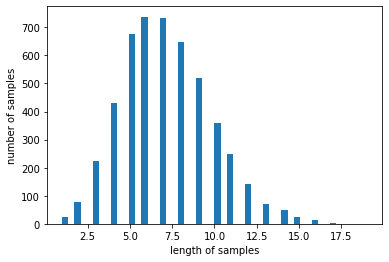

In [38]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [39]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [40]:
max_len = 12
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 12 이하인 샘플의 비율: 96.63528940516724


In [15]:
max_len = 17
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 17 이하인 샘플의 비율: 99.93996397838704


In [42]:
X_train = pad_sequences(X_train, maxlen=max_len)  # 길이가 같지 않고 적거나 많을 때 일정한 길이로 맞춰 줄 때 사용(padding)
X_test = pad_sequences(X_test, maxlen=max_len)    

In [43]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))   # sigmoid # softmax

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
63/63 [==============================] - ETA: 0s - loss: 0.5307 - acc: 0.7354
Epoch 00001: val_acc improved from -inf to 0.80380, saving model to best_model.h5
63/63 [==============================] - 6s 58ms/step - loss: 0.5307 - acc: 0.7354 - val_loss: 0.3939 - val_acc: 0.8038
Epoch 2/15
63/63 [==============================] - ETA: 0s - loss: 0.2846 - acc: 0.8881
Epoch 00002: val_acc improved from 0.80380 to 0.84785, saving model to best_model.h5
63/63 [==============================] - 2s 36ms/step - loss: 0.2846 - acc: 0.8881 - val_loss: 0.3386 - val_acc: 0.8478
Epoch 3/15
63/63 [==============================] - ETA: 0s - loss: 0.2112 - acc: 0.9181
Epoch 00003: val_acc improved from 0.84785 to 0.86286, saving model to best_model.h5
63/63 [==============================] - 2s 39ms/step - loss: 0.2112 - acc: 0.9181 - val_loss: 0.3321 - val_acc: 0.8629
Epoch 4/15
62/63 [============================>.] - ETA: 0s - loss: 0.1690 - acc: 0.9370
Epoch 00004: val_acc did not imp

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='relu'))       #relu  #softmax - 개떨어짐

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])     #optimizer = 'rmsprop'
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
62/63 [============================>.] - ETA: 0s - loss: 0.7707 - acc: 0.6247
Epoch 00001: val_acc improved from -inf to 0.80000, saving model to best_model.h5
63/63 [==============================] - 6s 56ms/step - loss: 0.7679 - acc: 0.6267 - val_loss: 0.5030 - val_acc: 0.8000
Epoch 2/15
63/63 [==============================] - ETA: 0s - loss: 0.3075 - acc: 0.8899
Epoch 00002: val_acc improved from 0.80000 to 0.84600, saving model to best_model.h5
63/63 [==============================] - 3s 42ms/step - loss: 0.3075 - acc: 0.8899 - val_loss: 0.4954 - val_acc: 0.8460
Epoch 3/15
62/63 [============================>.] - ETA: 0s - loss: 0.4286 - acc: 0.8175
Epoch 00003: val_acc did not improve from 0.84600
63/63 [==============================] - 2s 35ms/step - loss: 0.4278 - acc: 0.8179 - val_loss: 0.5934 - val_acc: 0.7510
Epoch 4/15
61/63 [============================>.] - ETA: 0s - loss: 0.2682 - acc: 0.9042
Epoch 00004: val_acc did not improve from 0.84600
63/63 [==========

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))       #relu  #softmax - 개떨어짐

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])     #optimizer = 'rmsprop'
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
63/63 [==============================] - ETA: 0s - loss: 0.5507 - acc: 0.7373
Epoch 00001: val_acc improved from -inf to 0.81900, saving model to best_model.h5
63/63 [==============================] - 6s 45ms/step - loss: 0.5507 - acc: 0.7373 - val_loss: 0.3874 - val_acc: 0.8190
Epoch 2/15
63/63 [==============================] - ETA: 0s - loss: 0.2462 - acc: 0.9024
Epoch 00002: val_acc improved from 0.81900 to 0.84500, saving model to best_model.h5
63/63 [==============================] - 2s 39ms/step - loss: 0.2462 - acc: 0.9024 - val_loss: 0.3462 - val_acc: 0.8450
Epoch 3/15
63/63 [==============================] - ETA: 0s - loss: 0.1423 - acc: 0.9497
Epoch 00003: val_acc did not improve from 0.84500
63/63 [==============================] - 2s 37ms/step - loss: 0.1423 - acc: 0.9497 - val_loss: 0.3874 - val_acc: 0.8360
Epoch 4/15
63/63 [==============================] - ETA: 0s - loss: 0.0946 - acc: 0.9695
Epoch 00004: val_acc did not improve from 0.84500
63/63 [==========

(array([1138.,  328.,  213.,  159.,  138.,  126.,  101.,  114.,  101.,
          90.,   92.,   82.,   98.,   70.,   99.,  113.,  121.,  179.,
         254., 1384.]),
 array([3.1498428e-05, 5.0029803e-02, 1.0002811e-01, 1.5002641e-01,
        2.0002472e-01, 2.5002304e-01, 3.0002132e-01, 3.5001963e-01,
        4.0001795e-01, 4.5001626e-01, 5.0001454e-01, 5.5001289e-01,
        6.0001117e-01, 6.5000945e-01, 7.0000780e-01, 7.5000608e-01,
        8.0000436e-01, 8.5000271e-01, 9.0000099e-01, 9.4999933e-01,
        9.9999762e-01], dtype=float32),
 <a list of 20 Patch objects>)

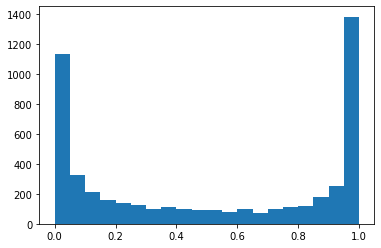

In [44]:
loaded_model = load_model('best_model.h5')
pred = loaded_model.predict(X_test)
plt.hist(pred, bins=20)

In [45]:
result = [0 if val < 0.5 else 1 for val in pred]
sub['label'] = result
sub.to_csv("submission10.csv", index=False) # 0.848

In [46]:
from collections import Counter
Counter(result)

Counter({0: 2508, 1: 2492})